In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

from myfunc.features.briefRotTest import rotation_matrix
from myfunc.features.planarH import computeH
from myfunc.mysubplot import subplots

### Compute homography

In [2]:
rotate_45 = np.array([[0.707, 0.707], [-0.707, 0.707]])
src_pairs = np.array([[124, 310], [127, 197], [141, 191], [143, 172]])
# dst_pairs = np.array([[306,466],[229,384],[235,370], [222.7, 356]])
dst_pairs = np.matmul(rotate_45, src_pairs.T).T

H1 = computeH(dst_pairs, src_pairs, 4)
H2, mask = cv.findHomography(src_pairs, dst_pairs)

In [3]:
H1,H2

(array([[ 7.07000000e-01,  7.07000000e-01, -8.19975098e-09],
        [-7.07000000e-01,  7.07000000e-01, -1.72636171e-09],
        [ 2.16407662e-13,  2.91299518e-14,  1.00000000e+00]]),
 array([[ 7.07126230e-01,  7.07053383e-01, -1.38356554e-02],
        [-7.07025071e-01,  7.07044598e-01, -2.85230512e-03],
        [ 3.63361905e-07,  4.75992874e-08,  1.00000000e+00]]))

### Load source and destination images

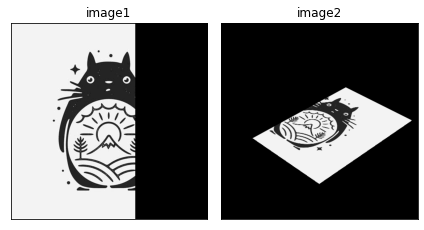

In [34]:
image1 = np.loadtxt('../../data/ass3/img_1.txt', delimiter=",").astype(np.uint8)
image2 = np.loadtxt('../../data/ass3/img_2.txt', delimiter=",").astype(np.uint8)

subplots([image1, image2], ['image1', 'image2'], 1, 2)

### SIFT

In [3]:
MIN_MATCH_COUNT = 10
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(image1,None)
kp2, des2 = sift.detectAndCompute(image2,None)
# find matches with kd-tree
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

### Matching with RANSAC 

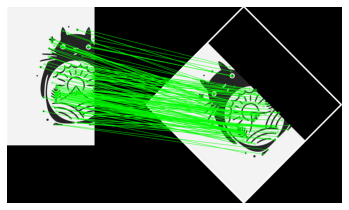

In [4]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = image1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(image2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
matches = cv.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)
plt.axis('off')
plt.imshow(matches, cmap='gray')

### Image stitching

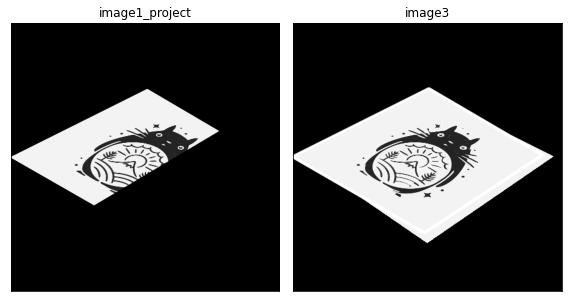

In [12]:
fig = plt.subplots(nrows=1, ncols=2, figsize=(8, 16))
image1_proj = cv.warpPerspective(image1,M,(h,w))
image3 = np.maximum(image1_proj, image2)
subplots([image1_proj, image3], ['image1_project', 'image3'], 1, 2)